In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym
from matplotlib import pyplot as plt
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
import numpy as np
import neat
import pickle
import cv2
import visualize
import csv

Création de notre environnement 

In [2]:
env = gym.make('SuperMarioBros-v2', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
#env = GrayScaleObservation(env, keep_dim=True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v2 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [3]:
def eval_genomes(genomes,config):
    global generation
    generation+=1
    for genome_id, genome in genomes:

        net = neat.nn.recurrent.RecurrentNetwork.create(genome, config)

        done = False
        obs,info= env.reset()
        i=0
        fitness=0
        fitness_max=41

        while done==False:

            
             #RuntimeError: Expected 1120 inputs, got 61440
            obs = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
            screen = cv2.resize(obs, (28, 40))

            # Aplatir l'image résultante
            screen = np.ndarray.flatten(screen)



            output = net.activate(screen)
            output=output.index(max(output))
            
            obs, reward, terminated, truncated, info = env.step(output)

            done = terminated or truncated
            fitness=info["x_pos"]
            if fitness>fitness_max:
                i=0
                fitness_max=fitness
            else:
                i+=1
            
            if done or i>200 or info["life"]<2:
                done=True

                with open('donnees_evolution.csv', 'a', newline='') as csvfile:
                    fieldnames = ['generation', 'genome_id', 'fitness_max']
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                    if csvfile.tell() == 0:
                        writer.writeheader()
                    writer.writerow({'generation': generation, 'genome_id': genome_id, 'fitness_max': fitness_max})
                genome.fitness = int(fitness_max)

                #print("Generation  : {}  Genome : {}   Score : {}".format(generation, genome_id, fitness_max))
                genome.fitness=int(fitness_max)

            if info["flag_get"]==True:
                done=True
                genome.fitness=120000
                
                with open('donnees_evolution.csv', 'a', newline='') as csvfile:
                    fieldnames = ['generation', 'genome_id', 'fitness_max']
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                    if csvfile.tell() == 0:
                        writer.writeheader()
                    writer.writerow({'generation': generation, 'genome_id': genome_id, 'fitness_max': 120000})


In [4]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config-feedforward')


pop = neat.Checkpointer.restore_checkpoint('neat-checkpoint-399')
#pop = neat.Population(config)

global generation
generation=398
pop.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
pop.add_reporter(stats)
pop.add_reporter(neat.Checkpointer(20))
#winner=pop.run(eval_genomes, 2)
winner = pop.run(eval_genomes)
with open("winner-feedforwars","wb") as filename:
    pickle.dump(winner,filename)


 ****** Running generation 399 ****** 



2024-02-01 20:48:36.124 Python[10909:395485] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/tl/wt49_5lx4417kf9r881g39p40000gn/T/org.python.python.savedState
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neat/aggregations.py:18: RuntimeWarning: overflow encountered in scalar multiply
  return reduce(mul, x, 1.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neat/aggregations.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  return reduce(mul, x, 1.0)


Population's average fitness: 738.10345 stdev: 597.37791
Best fitness: 2163.00000 - size: (9, 1980) - species 9 - id 536
Average adjusted fitness: 0.281
Mean genetic distance 2.037, standard deviation 0.711
Population of 29 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     9  142    11   2163.0    0.394    47
    12   37     9   2015.0    0.188    30
    13   34     9   2015.0    0.259    11
Total extinctions: 0
Generation time: 229.701 sec
Saving checkpoint to neat-checkpoint-399

 ****** Running generation 400 ****** 

Population's average fitness: 638.58621 stdev: 537.71018
Best fitness: 2163.00000 - size: (9, 1980) - species 9 - id 536
Average adjusted fitness: 0.279
Mean genetic distance 2.068, standard deviation 0.685
Population of 30 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     9  143    12   2163.0    0.317    48
    12   38    10   2015.0    0.290    3

In [ ]:
with open("winner-feedforwars","wb") as filename:
    pickle.dump(winner,filename)

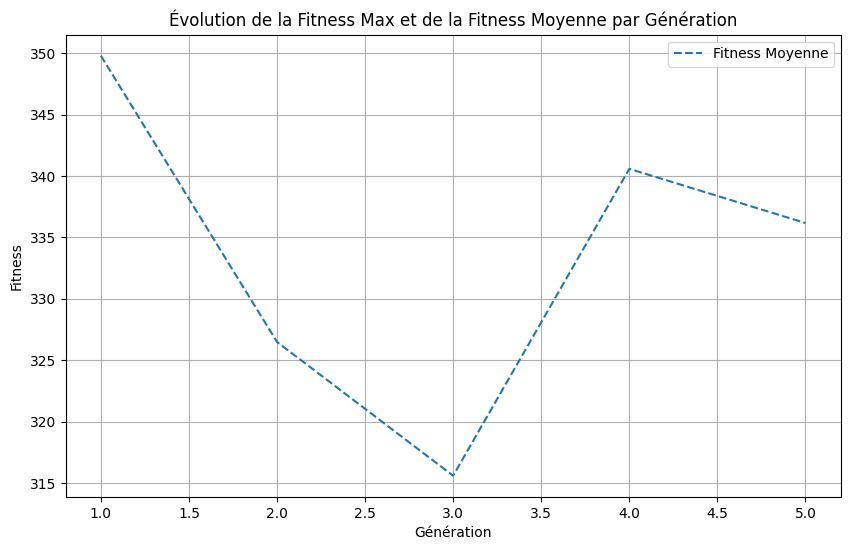

In [ ]:
#Graphique

import pandas as pd
import matplotlib.pyplot as plt

# Charger les données à partir du fichier CSV
df = pd.read_csv('donnees_evolution.csv')

# Calculer la Fitness Moyenne par génération
fitness_moyenne_par_generation = df.groupby('generation')['fitness_max'].mean().reset_index()
fitness_max_par_generation = df.groupby('generation')['fitness_max'].max().reset_index()

# Créer un graphique
plt.figure(figsize=(10, 6))

plt.plot(fitness_moyenne_par_generation['generation'], fitness_moyenne_par_generation['fitness_max'], label='Fitness Moyenne', linestyle='--')
plt.plot(fitness_max_par_generation['generation'], fitness_max_par_generation['fitness_max'], label='Fitness Moyenne', linestyle='x')

plt.xlabel('Génération')
plt.ylabel('Fitness')
plt.legend()
plt.title('Évolution de la Fitness Max et de la Fitness Moyenne par Génération')
plt.grid(True)
plt.show()
